<a href="https://colab.research.google.com/github/alvumu/BDGE/blob/main/ClickHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ClickHouse**
ClickHouse representa un sistema de gestión de bases de datos (DBMS) de código abierto, centrado en columnas y diseñado específicamente para el procesamiento analítico en línea (OLAP). Esta herramienta innovadora fue desarrollada por Yandex y actualmente impulsa la segunda plataforma de análisis web más extensa, Yandex Metrica. Destacando como el primer almacén de datos SQL de código abierto, ClickHouse ha logrado igualar y superar la escalabilidad y rendimiento de bases de datos reconocidas como Veryica y Snowflake. Su enfoque columnar, combinado con una eficiente gestión de datos, lo posiciona como una opción destacada para abordar desafíos analíticos en entornos que demandan respuestas rápidas y procesamiento eficaz de grandes volúmenes de datos.




# Características

Algunas de las características que ofrece este sistema de gestión de bases de datos son los siguientes :  

* Una base de datos orientada a **columna**, sólo almacena los datos.
* Los **datos** se comprimen reduciendo el espacio y se **almacenan** en **disco**
* Capaz de **procesar** en **paralelo** los datos exprimiendo las capacidades multicores de los servidores.
* Destaca por procesar datos mediante vectores, **optimizando** la **eficiencia** de la CPU
* Utiliza el **lenguaje SQL** para ejecución de las sentencias.
* Permite **actualizar** los **datos en tiempo real** sin bloqueo.
* Proporciona **indexación** por **clave primaria**. Hace posible recuperar la información almacenada para un determinado valor o un rango de valores con muy baja latencia y pocos milisegundos.
* Puede trabajar con millones de registros en bruto (sin realizar preprocesamientoo previo de los datos) consiguiendo ejecutar **sentencias sin ninguna latencia**
* Soporte de **replicación** e **integridad** de datos.



# Instalación

A continuación, se procede a la instalación del software de ClickHouse en un entorno Python, con el objetivo de habilitar su uso en Google Colab. Se proporcionarán instrucciones detalladas sobre los pasos necesarios para lograr una integración exitosa de ClickHouse con Python.

In [1]:
!pip install clickhouse-connect
!pip install clickhouse-driver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.5/964.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 6.4 MB/s eta 0:00:00



Para conectarnos a ClickHouse necesitamos :
*   **Host** : El host al que deseamos conectarnos
*   **Puerto** : El puerto en el que estará escuchando el host, habitualmente el 8443
*   **Nombre de usuario** : El usuario por defecto es '*default*'
*   **Contraseña** : Contraseña necesaria para establecer la conexión





La información requerida se puede obtener gracias a la interfaz de ClickHouse SQL.


En primer lugar, tras habernos registrado en ClickHouse, accedemos a la dirección https://clickhouse.cloud/services . Donde encontraremos lo siguiente:

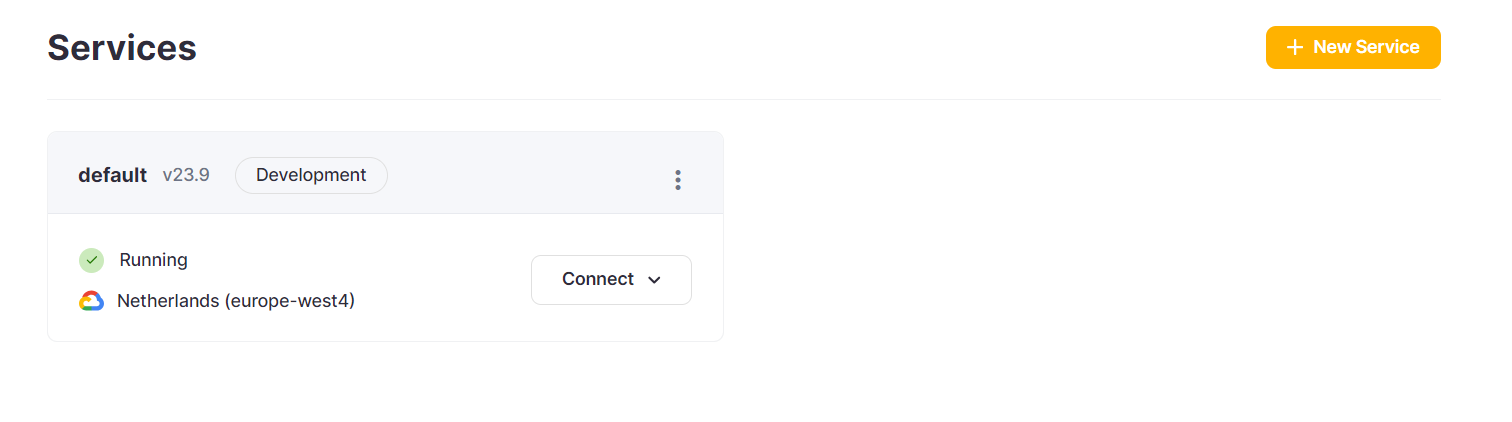

Para conocer la información de conexión necesaria , hacemos click en la pestaña que indica *Connect*

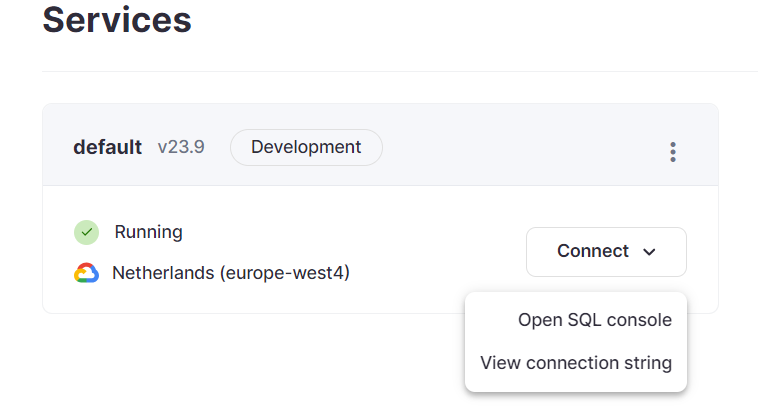

Tras esto, se nos abrirá un desplegable , donde seleccionaremos *View connection string*

A continuación se mostrará la siguiente pantalla:


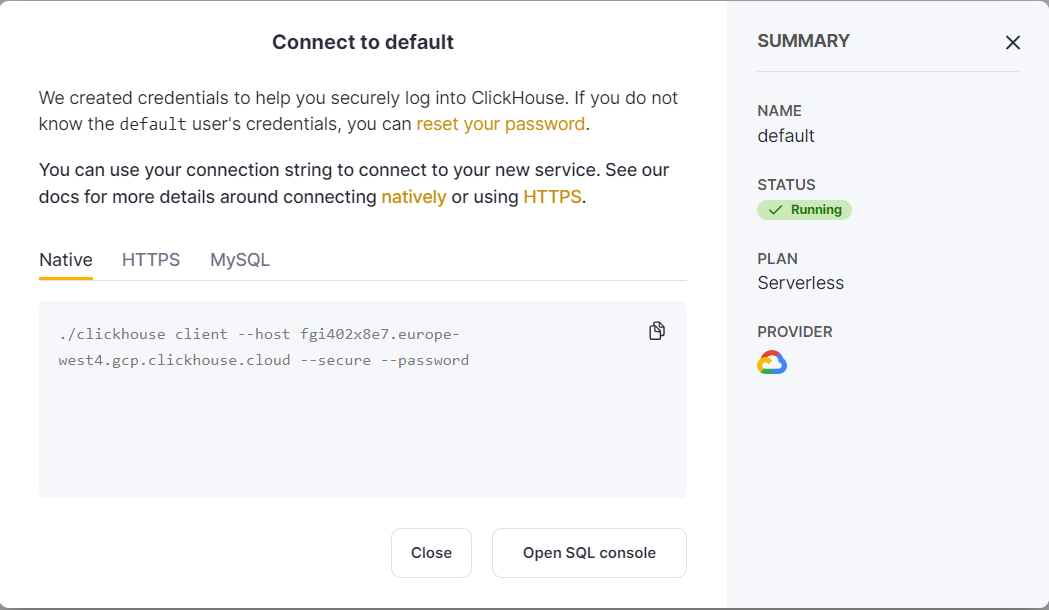


Aquí podemos observar la información necesaria para llevar a cabo la conexión. Por lo tanto podemos proceder a conectarnos al cliente mediante la función *`get_client`*

In [2]:
import clickhouse_connect

client = clickhouse_connect.get_client(host='fgi402x8e7.europe-west4.gcp.clickhouse.cloud', port=8443, username='default', password='SY_rjdkJKk7oU')

# Importación de datos

Se define una función para extraer y descargar los archivos en el entorno para su posterior carga en Clickhouse

In [3]:
import gzip
from urllib.request import Request,urlopen
import io
import os
import os.path as path

def download_csv(baseurl, filename):
    file = path.abspath(path.join(os.getcwd(),filename))
    request = Request(baseurl + filename + '.gz')
    response = urlopen(request)
    buf = io.BytesIO(response.read())
    f = gzip.GzipFile(fileobj=buf)
    data = f.read()
    with open (filename, 'wb') as ff:
      ff.write(data)

baseurl = 'https://raw.githubusercontent.com/dsevilla/bdge-data/master/es.stackoverflow/'
download_csv(baseurl, 'Posts.csv')
download_csv(baseurl, 'Users.csv')
download_csv(baseurl, 'Tags.csv')
download_csv(baseurl, 'Comments.csv')
download_csv(baseurl, 'Votes.csv')

Se crea una base de datos donde se almacenarán las tablas relacionadas con el trabajo. Esta base de datos tendrá el nombre *stackoverflow*

In [4]:
client.query("CREATE DATABASE IF NOT EXISTS stackoverflow")

Se define la tabla que almacenará la información relativa a los Post

In [5]:
client.query("DROP TABLE IF EXISTS stackoverflow.PostsPart")
client.query("""
CREATE TABLE IF NOT EXISTS stackoverflow.PostsPart
(
    Id Int32,
    AcceptedAnswerId Nullable(Int32) DEFAULT NULL,
    AnswerCount Nullable(Int32) DEFAULT 0,
    Body String,
    ClosedDate Nullable(DateTime) DEFAULT NULL,
    CommentCount Nullable(Int32) DEFAULT 0,
    CommunityOwnedDate Nullable(DateTime) DEFAULT NULL,
    CreationDate Nullable(DateTime) DEFAULT NULL,
    FavoriteCount Nullable(Int32) DEFAULT 0,
    LastActivityDate Nullable(DateTime) DEFAULT NULL,
    LastEditDate Nullable(DateTime) DEFAULT NULL,
    LastEditorDisplayName String,
    LastEditorUserId Nullable(Int32) DEFAULT NULL,
    OwnerDisplayName String,
    OwnerUserId Nullable(Int32) DEFAULT NULL,
    ParentId Nullable(Int32) DEFAULT NULL,
    PostTypeId UInt8,
    Score Int32 DEFAULT 0,
    Tags String,
    Title String,
    ViewCount Nullable(Int32) DEFAULT 0
) ENGINE = MergeTree
 PRIMARY KEY Id
 ORDER BY Id;""")

Tras crear la tabla, se importan que completarán la tabla. Para ello se usa la función **insert_file**

In [6]:
from clickhouse_connect.driver.tools import insert_file

insert_file(client, 'PostsPart', 'Posts.csv',
            settings={'input_format_allow_errors_ratio': .2,
                      'input_format_allow_errors_num': 5},
            database = "stackoverflow")


Comprobamos que los datos se han añadido a la tabla correctamente

In [7]:
q = client.query('SELECT count(*) FROM stackoverflow.PostsPart')
q.result_columns

[[76278]]

Se repite el mismo procedimiento para los distintos ficheros


In [8]:
client.query("DROP TABLE IF EXISTS stackoverflow.Users")
client.query("""
CREATE TABLE IF NOT EXISTS stackoverflow.Users
(
    Id Int32,
    AboutMe String,
    AccountID Int32,
    Age Nullable(Int32),
    CreationDate Nullable(DateTime),
    DisplayName String,
    DownVotes Nullable(Int32) DEFAULT 0,
    LastAccessDate Nullable(Datetime),
    Location String,
    ProfileImageUrl String,
    Reputation Nullable(Int32) DEFAULT 0,
    UpVotes Nullable(Int32) DEFAULT 0,
    Views Nullable(Int32) DEFAULT 0,
    WebsiteUrl String
) ENGINE = MergeTree
 PRIMARY KEY Id
 ORDER BY Id;""")

insert_file(client, 'Users', 'Users.csv',
            settings={'input_format_allow_errors_ratio': .2,
                      'input_format_allow_errors_num': 5},
            database = "stackoverflow")


In [9]:

client.query("DROP TABLE IF EXISTS stackoverflow.Tags")
client.query("""
CREATE TABLE IF NOT EXISTS stackoverflow.Tags
(
    Id Int32,
    Count Int32 DEFAULT 0,
    ExcerptPostId Nullable(Int32) DEFAULT NULL,
    TagName String,
    WikiPostId Nullable(Int32) DEFAULT NULL,
) ENGINE = MergeTree()
 PRIMARY KEY Id
 ORDER BY Id;""")

insert_file(client, 'Tags', 'Tags.csv',
            settings={'input_format_allow_errors_ratio': .2,
                      'input_format_allow_errors_num': 5},
            database = "stackoverflow")


In [10]:
client.query("DROP TABLE IF EXISTS stackoverflow.Votes")
client.query("""
CREATE TABLE IF NOT EXISTS stackoverflow.Votes
(
    Id Int32,
    BountyAmount Int32 DEFAULT 0,
    CreationDate Nullable(DateTime) DEFAULT NULL,
    PostId Nullable(Int32) DEFAULT NULL,
    UserId Nullable(Int32) DEFAULT NULL,
    VoteTypeId Int32,
) ENGINE = MergeTree()
 PRIMARY KEY Id
 ORDER BY Id;""")

insert_file(client, 'Votes', 'Votes.csv',
            settings={'input_format_allow_errors_ratio': .2,
                      'input_format_allow_errors_num': 5},
            database = "stackoverflow")

In [11]:
client.query("DROP TABLE IF EXISTS stackoverflow.Comments")
client.query("""
CREATE TABLE IF NOT EXISTS stackoverflow.Comments
(
    Id Int32,
    CreationDate Nullable(DateTime) DEFAULT NULL,
    PostId Nullable(Int32) DEFAULT NULL,
    Score Int32 DEFAULT 0,
    Text String,
    UserDisplayName String,
    UserId Nullable(Int32) DEFAULT NULL

) ENGINE = MergeTree

 PRIMARY KEY Id
 ORDER BY Id;""")

insert_file(client, 'Comments', 'Comments.csv',
            settings={'input_format_allow_errors_ratio': .2,
                      'input_format_allow_errors_num': 5},
            database = "stackoverflow")

In [12]:
q = client.query('SELECT count(*) FROM stackoverflow.Users')
q.result_columns

[[49033]]

In [13]:
q = client.query('SELECT count(*) FROM stackoverflow.Votes')
q.result_columns

[[165621]]

In [14]:
q = client.query('SELECT count(*) FROM stackoverflow.Tags')
q.result_columns

[[1554]]

In [15]:
q = client.query('SELECT count(*) FROM stackoverflow.Comments')
q.result_columns

[[123662]]

# Ejercicios

A continuación se realizan los ejercicios relativos a los RQ´s



## RQ1
¿Cual es la distribucion de desarrolladores que postean preguntas ?



In [16]:
rq1 = client.query("""SELECT
    QuestionCount,
    COUNT(*) AS CantidadDevs
FROM (
    SELECT
        OwnerUserId AS DeveloperId,
        COUNT(*) AS QuestionCount
    FROM stackoverflow.PostsPart
    WHERE PostTypeId = 1
    GROUP BY OwnerUserId
) AS R
GROUP BY QuestionCount
ORDER BY QuestionCount
""")



In [17]:
rq1.result_rows

[(1, 6840),
 (2, 1603),
 (3, 706),
 (4, 407),
 (5, 295),
 (6, 184),
 (7, 142),
 (8, 105),
 (9, 76),
 (10, 79),
 (11, 49),
 (12, 43),
 (13, 34),
 (14, 37),
 (15, 35),
 (16, 24),
 (17, 20),
 (18, 13),
 (19, 19),
 (20, 20),
 (21, 15),
 (22, 16),
 (23, 9),
 (24, 16),
 (25, 10),
 (26, 12),
 (27, 5),
 (28, 6),
 (29, 11),
 (30, 9),
 (31, 4),
 (32, 4),
 (33, 3),
 (34, 2),
 (35, 4),
 (36, 3),
 (37, 6),
 (38, 2),
 (39, 4),
 (40, 2),
 (41, 3),
 (42, 1),
 (43, 4),
 (44, 2),
 (45, 3),
 (46, 3),
 (47, 4),
 (48, 5),
 (49, 2),
 (50, 4),
 (51, 3),
 (54, 1),
 (55, 2),
 (56, 1),
 (60, 1),
 (62, 2),
 (64, 2),
 (69, 1),
 (71, 1),
 (72, 1),
 (75, 1),
 (79, 1),
 (83, 2),
 (84, 1),
 (85, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (107, 1),
 (111, 1),
 (114, 1),
 (115, 1),
 (119, 2),
 (130, 1),
 (144, 1),
 (158, 1),
 (177, 1),
 (223, 1)]

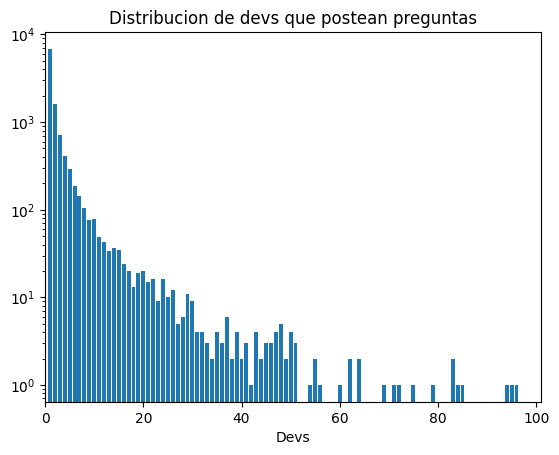

In [18]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import pandas as pd

df = pd.DataFrame(rq1.result_rows, columns=['QuestionCount', 'CantidadDevs'])

print(df)
plt.bar(df["QuestionCount"][0:100], df["CantidadDevs"][0:100])
plt.xlim(0,101)
plt.yscale("log")
plt.title("Distribucion de devs que postean preguntas")
plt.xlabel("Devs")

# Muestra la gráfica
display(plt.gcf())

# Borra la salida de texto
clear_output(wait=True)


##RQ2
¿Cual es la distribucion de desarrolladores que contestan preguntas?

In [28]:
rq2 = client.query("""
SELECT
    QuestionCount,
    COUNT(*) AS CantidadDevs
FROM (
    SELECT
        OwnerUserId AS DeveloperId,
        COUNT(*) AS QuestionCount
    FROM stackoverflow.PostsPart
    WHERE PostTypeId = 2
    GROUP BY OwnerUserId
) AS R
GROUP BY QuestionCount
ORDER BY QuestionCount
""")


In [20]:
rq2.result_rows

[(1, 3358),
 (2, 998),
 (3, 450),
 (4, 263),
 (5, 194),
 (6, 145),
 (7, 108),
 (8, 71),
 (9, 81),
 (10, 51),
 (11, 41),
 (12, 31),
 (13, 32),
 (14, 20),
 (15, 18),
 (16, 19),
 (17, 27),
 (18, 23),
 (19, 19),
 (20, 11),
 (21, 17),
 (22, 13),
 (23, 10),
 (24, 8),
 (25, 8),
 (26, 10),
 (27, 3),
 (28, 7),
 (29, 8),
 (30, 8),
 (31, 4),
 (32, 11),
 (33, 6),
 (34, 2),
 (35, 9),
 (36, 4),
 (37, 3),
 (38, 5),
 (39, 3),
 (40, 2),
 (41, 4),
 (42, 5),
 (43, 3),
 (44, 2),
 (45, 1),
 (46, 8),
 (47, 2),
 (48, 6),
 (49, 2),
 (50, 3),
 (51, 5),
 (52, 3),
 (53, 7),
 (54, 1),
 (55, 4),
 (56, 2),
 (57, 2),
 (62, 1),
 (64, 2),
 (65, 1),
 (66, 4),
 (68, 1),
 (69, 3),
 (70, 1),
 (72, 1),
 (74, 1),
 (75, 2),
 (76, 1),
 (77, 2),
 (78, 2),
 (80, 2),
 (81, 4),
 (82, 1),
 (83, 1),
 (84, 2),
 (86, 1),
 (88, 1),
 (89, 2),
 (90, 1),
 (93, 2),
 (97, 3),
 (98, 1),
 (100, 1),
 (102, 2),
 (104, 2),
 (105, 2),
 (107, 1),
 (108, 1),
 (109, 1),
 (110, 2),
 (112, 2),
 (114, 2),
 (117, 1),
 (118, 1),
 (125, 1),
 (126, 1),
 (

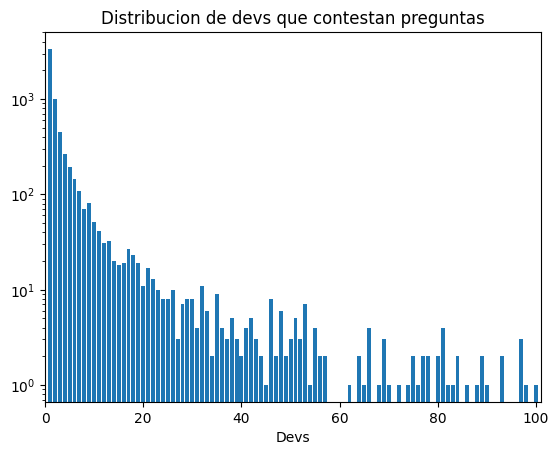

In [21]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import pandas as pd

df = pd.DataFrame(rq2.result_rows, columns=['QuestionCount', 'CantidadDevs'])

print(df)
plt.bar(df["QuestionCount"][0:100], df["CantidadDevs"][0:100])
plt.xlim(0,101)
plt.yscale("log")
plt.title("Distribucion de devs que contestan preguntas")
plt.xlabel("Devs")

# Muestra la gráfica
display(plt.gcf())

# Borra la salida de texto
clear_output(wait=True)


## RQ3
¿ Los desarrolladores que preguntan tambien responden ?

In [30]:
rq3 = client.query("""
SELECT
    ResponseRange,
    COUNT(*) AS CountPerRange
FROM (
    SELECT
        CASE
            WHEN ResponsePercentage = 100 THEN '100%'
            WHEN ResponsePercentage > 100 THEN 'Más de 100%'
            WHEN ResponsePercentage < 1 THEN 'Nunca han respondido'
            WHEN ResponsePercentage < 10 THEN '1%-9%'
            WHEN ResponsePercentage < 20 THEN '10%-19%'
            WHEN ResponsePercentage < 30 THEN '20%-29%'
            WHEN ResponsePercentage < 40 THEN '30%-39%'
            WHEN ResponsePercentage < 50 THEN '40%-49%'
            WHEN ResponsePercentage < 60 THEN '50%-59%'
            WHEN ResponsePercentage < 70 THEN '60%-69%'
            WHEN ResponsePercentage < 80 THEN '70%-79%'
            WHEN ResponsePercentage < 90 THEN '80%-89%'
            WHEN ResponsePercentage < 100 THEN '90%-99%'
            ELSE 'Nunca han respondido'
        END AS ResponseRange
    FROM (
        SELECT
            OwnerUserId,
            COUNT(*) AS TotalPosts,
            SUM(CASE WHEN PostTypeId = 2 THEN 1 ELSE 0 END) AS Respuestas,
            (SUM(CASE WHEN PostTypeId = 2 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS ResponsePercentage
        FROM
            stackoverflow.PostsPart
        GROUP BY
            OwnerUserId
    ) AS a
) AS b
GROUP BY ResponseRange
ORDER BY ResponseRange

""")

In [31]:
rq3.result_rows

[('1%-9%', 125),
 ('10%-19%', 265),
 ('100%', 3543),
 ('20%-29%', 377),
 ('30%-39%', 376),
 ('40%-49%', 120),
 ('50%-59%', 776),
 ('60%-69%', 230),
 ('70%-79%', 154),
 ('80%-89%', 164),
 ('90%-99%', 135),
 ('Nunca han respondido', 8244)]

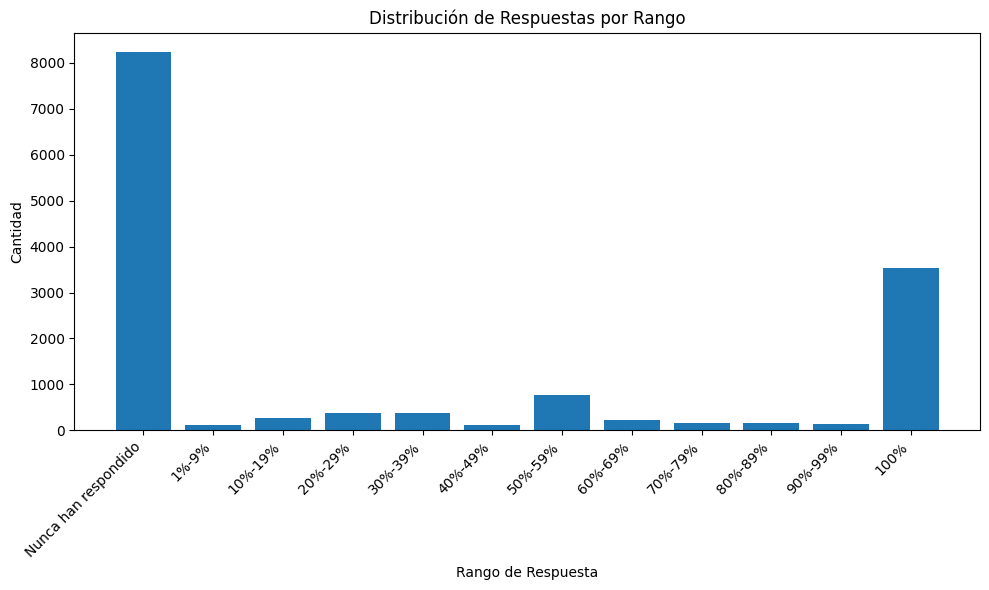

In [32]:
df = pd.DataFrame(rq3.result_rows, columns=['ResponseRange', 'CountPerRange'])

custom_order = [
    'Nunca han respondido', '1%-9%', '10%-19%', '20%-29%', '30%-39%', '40%-49%', '50%-59%',
    '60%-69%', '70%-79%', '80%-89%', '90%-99%', '100%', 'Más de 100%'
]

# Reordena los datos en el DataFrame según el orden personalizado
df['ResponseRange'] = pd.Categorical(df['ResponseRange'], categories=custom_order, ordered=True)
df = df.sort_values('ResponseRange')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df["ResponseRange"], df["CountPerRange"])

# Rotar las etiquetas del eje x para que sean legibles
plt.xticks(rotation=45, ha="right")

# Etiquetas para los ejes x e y
plt.xlabel("Rango de Respuesta")
plt.ylabel("Cantidad")

# Título del gráfico
plt.title("Distribución de Respuestas por Rango")

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## RQ4
¿ Los desarrolladores que reciben ayuda devuelven el favor ?

In [33]:
rq4 = client.query("""
-- Creamos una tabla que almacena Usuario que ha hecho la pregunta, Usuario al que ha respondido"
WITH PreguntasRespuestas AS (
    SELECT DISTINCT
        q.OwnerUserId AS AskedUser,
        a.OwnerUserId AS AnswerUser
    FROM
        stackoverflow.PostsPart AS q
        JOIN stackoverflow.PostsPart AS a ON q.Id = a.ParentId
    WHERE
        q.PostTypeId = 1
        AND a.PostTypeId = 2
)

SELECT
    qa1.AskedUser AS Pregunta1Usuario,
    qa2.AskedUser AS Pregunta2Usuario
FROM
    PreguntasRespuestas AS qa1
    JOIN PreguntasRespuestas AS qa2 ON qa1.AskedUser = qa2.AnswerUser
                                   AND qa2.AskedUser = qa1.AnswerUser
WHERE
    qa1.AskedUser < qa2.AskedUser
ORDER BY
    Pregunta1Usuario

""")


In [34]:
rq4.result_rows

[(21, 1184),
 (22, 729),
 (22, 342),
 (22, 288),
 (23, 25),
 (24, 95),
 (24, 463),
 (24, 301),
 (24, 19610),
 (24, 25),
 (24, 2230),
 (25, 288),
 (25, 225),
 (34, 250),
 (65, 78),
 (65, 13558),
 (65, 1184),
 (65, 7661),
 (73, 6497),
 (73, 29967),
 (73, 9897),
 (73, 2224),
 (73, 250),
 (78, 250),
 (83, 301),
 (83, 29967),
 (83, 100),
 (95, 29967),
 (100, 399),
 (100, 2004),
 (100, 729),
 (100, 2838),
 (100, 353),
 (100, 529),
 (100, 638),
 (100, 187),
 (120, 531),
 (154, 13938),
 (191, 2230),
 (227, 2004),
 (227, 400),
 (227, 342),
 (250, 10576),
 (250, 14243),
 (250, 18597),
 (250, 29967),
 (250, 2429),
 (250, 9897),
 (250, 2230),
 (250, 6491),
 (250, 12625),
 (250, 2163),
 (250, 729),
 (250, 27881),
 (250, 13938),
 (250, 13558),
 (250, 399),
 (250, 19610),
 (250, 731),
 (301, 2230),
 (342, 2367),
 (342, 517),
 (398, 547),
 (398, 2171),
 (399, 555),
 (463, 2742),
 (463, 19600),
 (463, 801),
 (517, 2676),
 (535, 2230),
 (638, 29967),
 (638, 35232),
 (729, 2224),
 (729, 1798),
 (729, 183

In [35]:
df = pd.DataFrame(rq4.result_rows, columns=['Pregunta1Usuario', 'Pregunta2Usuario'])
df

,Pregunta1Usuario,Pregunta2Usuario
0,21,1184
1,22,729
2,22,342
3,22,288
4,23,25
...,...,...
111,29967,39259
112,30877,31132
113,34270,46823
114,44942,44946


# Referencias

https://vasexperts.com/es/resources/glossary/clickhouse/ (ClickHouse)

https://www.adictosaltrabajo.com/2019/02/18/introduccion-a-clickhouse/#01 (Caracteristicas)

https://clickhouse.com/docs/en/integrations/python (Instalación)


